In [ ]:
# GET LIBRARIES
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
#from scipy import interpolate, signal
import scipy.interpolate
import scipy.signal

In [148]:
# DEFINE FUNCTIONS

def load_suite2p_outputs(directory_path): # loads all Suite2p output files from the specified directory into a pickled dictionary
    file_dict = {
        'roi_fluorescence': '*F.npy',
        'neuropil_fluorescence': '*Fneu.npy',
        'cell_identifier' : '*iscell.npy',
        'intermediate_outputs' : '*ops.npy',
        'roi_traces' : '*spks.npy',
        'roi_statistics' : '*stat.npy'}
    loaded_data_files = {}
    pathlist = Path(directory_path)
    for key, value in file_dict.items():
        suite2p_files = list(pathlist.glob(value))
        for file in suite2p_files:
            loaded_data_files[key] = np.load(file, allow_pickle = True)
    return loaded_data_files

def calculate_dff(raw, baseline): # calculates the dff values for each roi based on a calculated baseline fluorescence
    dff_list = []
    for row in range(len(raw)):
        dff = ((raw[row] - baseline[row])/(baseline[row]))
        dff_list.append(dff)
    dff = np.array(dff_list)
    return dff

def calculate_baseline(raw_fluorescence, percentile): # calculates the specified percentile along each roi's raw fluorescence to yield a baseline fluorescence value
    percentile_list = []
    for row in raw_fluorescence:
        find_percentile = np.percentile(row, percentile, keepdims = True)
        percentile_list.append(find_percentile)
    return percentile_list

def export_to_csv(dff_data, output_path):
    # Convert the list of ΔF/F arrays into a DataFrame
    dff_df = pd.DataFrame(dff_data)
    
    # Export to CSV
    dff_df.to_csv(output_path, index=False)
    print(f"ΔF/F data successfully exported to {output_path}")

In [ ]:
# LOAD DATA

# ROI DATA FROM SUITE2P
suite2p_data_output = load_suite2p_outputs(r'C:\Users\Sipe_Lab\OneDrive - The Pennsylvania State University\Sipe Lab\inbox\SB03_sal')
print(suite2p_data_output.keys())

# PSYCHOPY DATA
path = r"C:\Users\Sipe_Lab\OneDrive - The Pennsylvania State University\Sipe Lab\inbox\SB03_sal\sub-SB03_ses-01_20240807_133258.csv"
psychopy_trial_timestamps = pd.read_csv(path) # Load the CSV file into a pandas DataFrame
print(psychopy_trial_timestamps.columns) # List the columns from the DataFrame

# ENCODER DATA
encoder_file_path = r"C:\Users\Sipe_Lab\OneDrive - The Pennsylvania State University\Sipe Lab\inbox\SB03_sal\sub-SB03_ses-01_20240807_134316_wheeldf.csv" # define file path
encoder_trial_data = pd.read_csv(encoder_file_path) # read encoder data and relevant wheel info columns
print(encoder_trial_data.head()) # Display the first few rows of the DataFrame
print(encoder_trial_data.columns) # List the columns from the DataFrame


In [ ]:
# FILTER ROIs (CELLS ONLY)

# assign bool T/F based on confidence index
true_cells_only = suite2p_data_output['cell_identifier'][:,0].astype(bool)
print(true_cells_only)

# filter ROIs and neuropil based on bool value
filtered_roi = np.array(suite2p_data_output['roi_fluorescence'][true_cells_only])
filtered_neuropil = np.array(suite2p_data_output['neuropil_fluorescence'][true_cells_only])

In [151]:
# NEUROPIL SUBTRACTION
neuropil_subtracted_roi = (filtered_roi - (0.7*filtered_neuropil))

In [ ]:
# CALCULATE PERCENTILE BASELINE FLUORESCENCE
baseline_fluorescence = np.array(calculate_baseline(filtered_roi, percentile = 10))
print(baseline_fluorescence)

In [ ]:
# CALCULATE DF/F
roi_dff = calculate_dff(filtered_roi, baseline_fluorescence)
print(roi_dff)

In [ ]:
# SET SESSION VARIABLES (NUM ROIS, FRAMES, SESS DURATION, FRAME RATE)
offset_frames = 81 # offset amount of frames from GOS 
number_rois = len(filtered_roi)
num_frames = len(filtered_roi[0]) # number of frames in the session
new_number_frames = num_frames - offset_frames
neuro_frame_rate = 9.865 # fps from ThorImageLS metadata
rounded_frame_rate = 10 # round up fps to nearest whole number
session_dur = num_frames/rounded_frame_rate
#int((psychopy_trial_timestamps['display_gratings.stopped'].iloc[-1]) - (psychopy_trial_timestamps['display_gratings.started'].iloc[1])+1) #session duration rounded up by 1

print(number_rois)
print(num_frames)
print(new_number_frames)
print(session_dur)

In [ ]:
# CREATE TIME VECTORS FOR ROI SAMPLING AND PSYCHOPY SAMPLING

old_time_vector = np.linspace(0, (new_number_frames/neuro_frame_rate), num_frames) #this calculation makes a time vector based on the session duration and frame rate, so that it is understood how long a single frame is
print(old_time_vector[:25])
print(num_frames/neuro_frame_rate)
new_time_vector = np.linspace(0, (new_number_frames/rounded_frame_rate), num_frames) #this calculation makes a time vector based on the session duration and frame rate, so that it is understood how long a single frame is
print(new_time_vector[:25])
print(new_number_frames/rounded_frame_rate)

In [ ]:
# INTERPOLATE FRAMES
# this is basically interpolating data between frames to increase the frame rate to 10 fps

interpolated_roi = np.zeros(filtered_roi.shape) # create an array of zeros to fill in with interpolated data

for roi in filtered_roi:
    interpolated_roi = scipy.interpolate.CubicSpline(old_time_vector, filtered_roi, axis = 1)
    interpolated_result = interpolated_roi(new_time_vector)
    # interpolate_with_spline = scipy.interpolate.CubicSpline(old_time_vector, filtered_roi[roi]) # fit a spline function to the data of current ROI
    # interpolated_roi[roi, :] = interpolate_with_spline(new_time_vector) # apply the spline function to the new time vector and calculate interpolated values at the new points

#frame_time_vector = np.arange(1/rounded_frame_rate, len(new_time_vector)/rounded_frame_rate, 1/rounded_frame_rate)

print("Original fluorescence shape:", filtered_roi.shape)

print("Interpolated fluorescence shape:", interpolated_result.shape)

In [ ]:
# CALCULATE DFF FOR INTERPOLATED DATA
interpolated_dff = calculate_dff(interpolated_result, baseline_fluorescence)
print(interpolated_dff)


In [157]:
# SET THRESHOLDS FOR ACTIVITY 
min_events = 5 # threshold for number of events an ROI must exhibit to be considered active
min_distance = 3 # threshold for minimum distance (s) between events to be distinct
min_distance_frames = min_distance * rounded_frame_rate # convert min distance to frames
min_prominence = 0.5 # threshold for minimum amplitude for ROI event to be real
smoothing_kernel = 3 # time (frames) over which to smooth data

In [ ]:
# SMOOTH DATA

smoothed_roi_dff = [] # create an empty list to store smoothed dff values per roi

for roi in range(number_rois):
    smoothed_roi = np.convolve(interpolated_dff[roi] , np.ones(smoothing_kernel)/smoothing_kernel, mode='same') # convolution kernel is [0.33, 0.33, 0.33] 
    smoothed_roi_dff.append(smoothed_roi)
smoothed_roi_dff = np.array(smoothed_roi_dff)

print(smoothed_roi_dff)


In [ ]:
# FIND ACTIVE ROIS
active_rois = np.zeros((number_rois,1))


for roi in range(number_rois):
    roi_events, _ = scipy.signal.find_peaks(smoothed_roi_dff[roi], prominence = min_prominence, distance = min_distance_frames)
    active_rois[roi,0] = len(roi_events)
print(active_rois)
    

In [ ]:
# SET SESSION VISUAL STIM (GRATING) VARIABLES
trial_start = round(psychopy_trial_timestamps['display_gratings.started'][1:])
grating_start = round(psychopy_trial_timestamps['stim_grating.started'][1:])
grating_stop = round(psychopy_trial_timestamps['display_gratings.stopped'][1:])
grating_on = abs(grating_start - grating_stop) # 2 sec grating presentation
grating_off = abs(trial_start - grating_start) # 3 sec gray screen presentation
number_gratings = 8
number_trials = len(grating_on)/number_gratings #single cycle through all 8 gratings

print(grating_on)
print(grating_off)
print(number_trials)

In [ ]:
# PLOT RASTERS

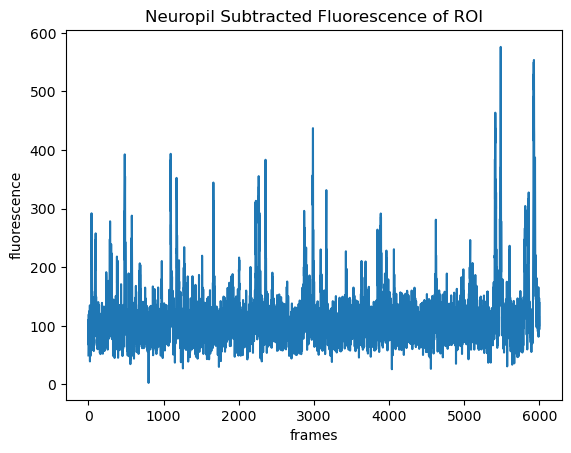

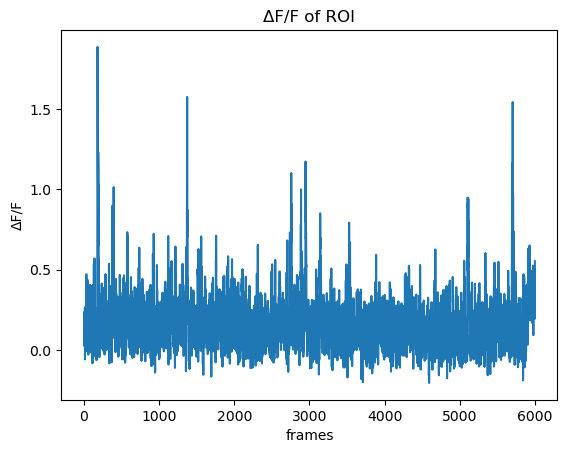

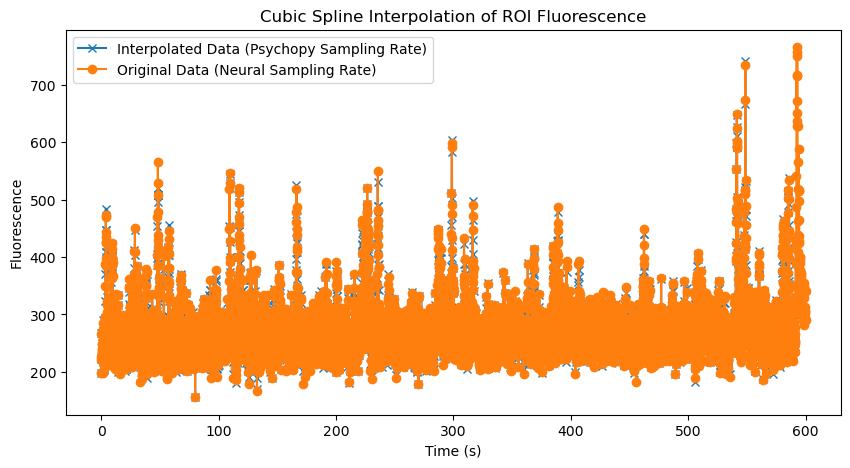

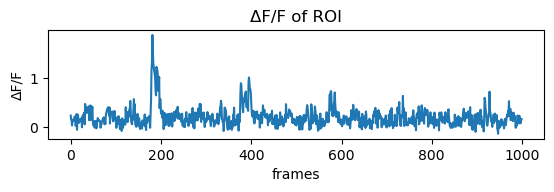

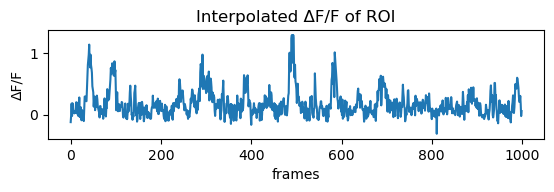

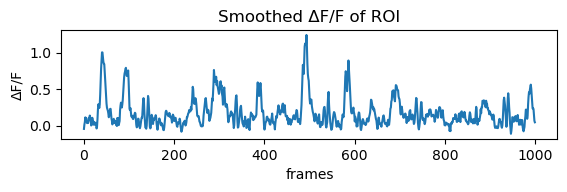

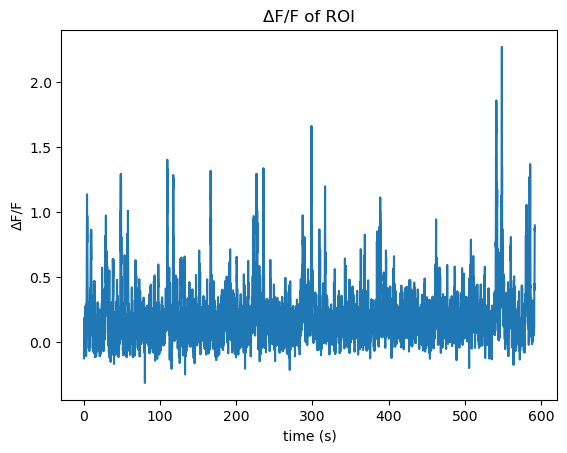

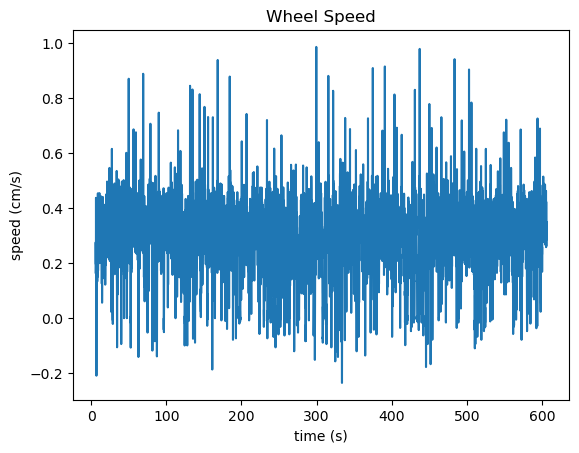

In [182]:
# PLOT DATA

# ROIS
plt.plot(neuropil_subtracted_roi[7])
plt.title('Neuropil Subtracted Fluorescence of ROI')
plt.xlabel('frames')
plt.ylabel('fluorescence')
plt.show()

# DFF
plt.plot(roi_dff[7])
plt.title('ΔF/F of ROI')    
plt.xlabel('frames')
plt.ylabel('ΔF/F')
plt.show()

# INTERPOLATED DATA OLD vs NEW
plt.figure(figsize=(10,5))
plt.plot(new_time_vector, interpolated_result[7], 'x-', label="Interpolated Data (Psychopy Sampling Rate)")
plt.plot(old_time_vector, filtered_roi[7], 'o-', label="Original Data (Neural Sampling Rate)")

plt.xlabel("Time (s)")
plt.ylabel("Fluorescence")
plt.legend()
plt.title("Cubic Spline Interpolation of ROI Fluorescence")
plt.show()

# ALL DFFS
plt.subplot(3,1,1)
plt.plot(roi_dff[7,:1000])
plt.title('ΔF/F of ROI')
plt.xlabel('frames')
plt.ylabel('ΔF/F')
plt.show()

plt.subplot(3,1,2)
plt.plot(interpolated_dff[7,:1000])
plt.title('Interpolated ΔF/F of ROI')
plt.xlabel('frames')
plt.ylabel('ΔF/F')
plt.show()

plt.subplot(3,1,3)
plt.plot(smoothed_roi_dff[7,:1000])
plt.title('Smoothed ΔF/F of ROI')
plt.xlabel('frames')
plt.ylabel('ΔF/F')
plt.show()

# INTERPOLATED DFF
plt.plot(new_time_vector, interpolated_dff[7])
plt.title('ΔF/F of ROI')
plt.xlabel('time (s)')
plt.ylabel('ΔF/F')
plt.show()

# ENCODER
plt.plot(encoder_trial_data['timestamp'], (-1*encoder_trial_data['speed']))
plt.title('Wheel Speed')
plt.xlabel('time (s)')
plt.ylabel('speed (cm/s)')
plt.show()